In [10]:
import random
import imageio
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Sequential, Model

In [11]:
def make_trainable(net, val, lr=0.001):
    net.model.trainable = val
    for l in net.model.layers:
        l.trainable = val
    net.cmpile(lr)
    
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # при замене оптимизатора всё слетает ???
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [12]:
# To generate data
class Dataset():
    x = None
    y = None
    W = None
    
    def __init__(self):
        return
    
    def load_data(self, data_range=4000):
        dots_x = []
        for i in range(data_range):
            x = random.gauss(0, data_range)
            dots_x.append((abs(x), x**2)) # square
            dots_x.append((abs(x), random.gauss(x**2, data_range**2.25))) # less than square
            #dots_x.append((x**r, x**(2*r*(1+random.gauss(0.5, 0.25)/20)))) # more than square
        dots_x = np.array(dots_x)
        #dots_y = np.array([random.uniform(0.75, 1.2) if x[0]**2 == x[1] else random.uniform(0, 0.3) for x in dots_x])
        dots_y = np.array([0 if x[0]**2 == x[1] else 1 for x in dots_x])
        self.x, self.y = dots_x, dots_y
        return dots_x, dots_y
    
    def load_weights(self, default_weight=0.12):
        W = self.y.copy().astype(float)
        W[W == 0] = 0.12
        self.W = W
        return W
        
    @staticmethod
    def load_random(n_dim=5, n_samples=16):
        V = np.random.normal(size=(n_samples, n_dim))
        return V
    

In [25]:
# To plot images
class Plot:
    name = ""
    images = []
    threshold = 0.0
    
    def __init__(self, name, threshold=0.6):
        self.name = name
        self.threshold = threshold
        self.images = []
    
    @staticmethod
    def parabola_plot(ax, xrange):
        x = np.linspace(xrange, 1)
        y = x*x
        plt.plot(x, y)
    
    @staticmethod
    def dots_plot(ax, dots_x, dots_y, color):
        ax.scatter(dots_x, dots_y, color=color, alpha=0.15)
        plt.plot()
    
    def picture(self, dots, predictions, title='', alpha=0.3):
        predictions = predictions.reshape(predictions.shape[0])
        dots_x = dots.T[0]
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        ax1.set(title=title)
        #ax2 = ax1.twinx()
        plt.grid(axis='both')
        xrange = (dots_x.min()*1.1, dots_x.max()*1.1)
        self.parabola_plot(ax1, xrange)
        ax1.scatter(dots.T[0], dots.T[1], c=predictions, cmap='YlOrRd', alpha=alpha)
        
    def add_to_gif(self, dots_x, predictions, title='', alpha=0.3):
        self.picture(dots_x, predictions, title=title, alpha=alpha)
        plt.savefig(self.name+'.png')
        plt.close()
        image = Image.open(self.name+'.png')
        ar = np.asarray(image)
        self.images.append(ar)
        
    def save_gif(self):
        kargs = { 'duration': 0.2 }
        imageio.mimsave(self.name+'.gif', self.images, None, **kargs)
        

In [14]:
# Classes for neural networks

# Generator
class Gen:
    model = None
    
    def __init__(self):
        model = Sequential([Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=5),
                            Dense(2, activation='linear')
        ])
        self.model = model
        
    def predict(self, dots_x):
        return self.model.predict(dots_x)
    
    def cmpile(self):
        return
    
# Discriminator
class Dsc:
    model = None
    
    def __init__(self):
        model = Sequential([Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=2),
                            Dense(1, activation='sigmoid')
        ])
        self.model = model
    
    def cmpile(self, lr=0.0001):
        self.model.compile(loss='binary_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(lr),
                           metrics=['accuracy'])
        
    def fit(self, dots_x, dots_y, weights=None, epochs=1, validation_split=0.15, plot=False):
        if plot:
            img = Plot('discriminator_fit')
            for i in range(epochs):
                print("Epoch %d out of %d" % (i, epochs))
                self.model.fit(dots_x, 
                               dots_y, 
                               epochs=5, 
                               sample_weight=weights)
                img.add_to_gif(dots_x, self.model.predict(dots_x), title='Epoch %d' % i)
            img.save_gif()                        
        else:
            self.model.fit(dots_x, 
                           dots_y, 
                           epochs=epochs, 
                           sample_weight=weights, 
                           validation_split=validation_split)
    
    def save(self, name='discriminator'):
        self.model.save(name+'.h5')
        
# !Raw class, doesn't work   
class Gan:
    gen = None
    dsc = None
    model = None
    
    def __init__(self, gen, dsc, n_dim=5):
        make_trainable(dsc, False)
        self.gen = gen
        self.dsc = dsc
        # connect them
        model = Sequential()
        # add generator
        model.add(gen.model)
        # add the discriminator
        model.add(dsc.model)
        self.model = model
    
    # This method doesn't work
    # Presumably because of some optimizer issue
    def cmpile(self, lr=0.001):
        self.model.compile(loss='binary_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(lr),
                           metrics = ['accuracy'])
        
    def fit(self, dots_x, dots_y, epochs=1):
        self.model.fit(dots_x, dots_y, epochs=epochs)
        
class Dummy:
    model = None
    
    def __init__(self, model):
        self.model = model
        
    def cmpile(self, lr=0.0001):
        self.model.compile(loss='binary_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(lr),
                           metrics=['accuracy'])
    
    # todo: remove hardcode
    def fit(self, dots_x, dots_y, weights=None, epochs=1, validation_split=0.15, plot=False):
        if plot:
            img = Plot('discriminator_fit')
            for i in range(epochs//25):
                print("Epoch %d out of %d" % (i, epochs))
                self.model.fit(dots_x, 
                               dots_y, 
                               epochs=25, 
                               sample_weight=weights)
                img.add_to_gif(dots_x, self.model.predict(dots_x), title='Epoch %d' % i*25)
            img.save_gif()                        
        else:
            self.model.fit(dots_x, 
                           dots_y, 
                           epochs=epochs, 
                           sample_weight=weights, 
                           validation_split=validation_split)
    
    def save(self, name='discriminator'):
        self.model.save(name+'.h5')
        

In [15]:
# Generating data
Data = Dataset()
Data.load_data()
weights = Data.load_weights()

# Defining neural networks
generator = Gen()
discriminator = Dsc()
gan = define_gan(generator.model, discriminator.model)

In [254]:
discriminator = tf.keras.models.load_model('discriminator.h5')

NameError: name 'copy' is not defined

In [28]:
def fit_discriminator(Data, epochs, lr=0.001):
    make_trainable(discriminator, True, lr=lr)
    discriminator.fit(Data.x, Data.y, epochs=epochs, plot=True)

In [257]:
discriminator2.model.trainable

True

In [30]:
# Training GAN
def fit_gan(Data, epochs):
    p = Plot('GAN_results')

    for i in range(epochs):
        V = Data.load_random(n_samples=1024)
        print("Epoch %d" % i)
        generated = generator.predict(V)
        if i % 50 == 0:
            p.add_to_gif(generated, np.ones(V.shape[0]), title='Epoch %d' % i, alpha=1)
        make_trainable(discriminator, False)
        print("Fitting GAN")
        gan.fit(V, np.ones(V.shape[0]))
        make_trainable(discriminator, True)
        print("Fitting discriminator")
        discriminator.fit(generated, np.zeros(V.shape[0]), weights=2*np.ones(V.shape[0]), validation_split=None)
    p.save_gif()

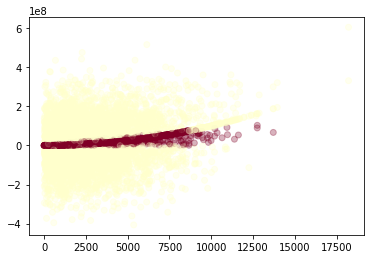

In [251]:
t = Plot('temporary')
plt.scatter(Data.x.T[0], Data.x.T[1], c=discriminator.predict(Data.x).reshape(8000,), cmap='YlOrRd', alpha=0.3)

In [199]:
discriminator.model.predict(np.array([[5, 0]]))

array([[1.]], dtype=float32)

In [ ]:
# Generating data
Data = Dataset()
Data.load_data()
weights = Data.load_weights()

# Defining neural networks
generator = Gen()
discriminator = Dsc()
gan = define_gan(generator.model, discriminator.model)

# Fitting
fit_discriminator(Data, 2000)
fit_gan(Data, 20000)